In [8]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import os
import matplotlib.pyplot as plt


In [9]:
# Prototype option:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # Set a fallback to CPU if MPS is not yet implemented

# Assign cuda to the device to use for training
if torch.cuda.is_available(): 
 dev = "cuda:0" 
 print("This model will run on CUDA")
# elif  torch.backends.mps.is_available(): 
#  dev = "mps:0"
#  print("This model will run on MPS")
else:
 dev = "cpu" 
 print("This model will run on CPU")
device = torch.device(dev) 

This model will run on CUDA


In [10]:
# Load the desired model and tokenizer
model_name = "80K"
output_dir = f"../7. Models/40K_GPT2_MDN_v2/"
model = GPT2LMHeadModel.from_pretrained(output_dir).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

In [11]:
# Load the validation dataset
val_file = f'./../3. Cleaned Data/MDN_40K_v2_val.csv'
val_df = pd.read_csv(val_file)

# During initial testing, will only choose 50 for speed
val_df = val_df.sample(50, random_state=123).reset_index()

In [12]:
# Function to generate predictions using the model
def generate_prediction(prompt, max_length=100, temperature=1.0, top_p=1.0):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
    with torch.no_grad():
        output = model.generate(
            input_ids, 
            attention_mask=attention_mask, 
            max_length=max_length, 
            num_return_sequences=1, 
            no_repeat_ngram_size=2,
            temperature=temperature,
            top_p=top_p,
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [13]:
# Calculate BLEU score and cosine distance
bleu_scores = []
cosine_distances = []

vectorizer = TfidfVectorizer()

In [14]:
for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    original = row['original']
    corrected = row['corrected']

    # Set max_length dynamically based on the length of the original text
    prompt = f"input: {original} output:"
    prompt_length = len(tokenizer.encode(prompt))
    dynamic_max_length = int(1.5 * len(original.split())) + prompt_length
    print(dynamic_max_length)

    # Generate prediction
    prediction = generate_prediction(prompt, max_length=dynamic_max_length, temperature=0.8, top_p=0.8)

    # Extract the actual generated output
    generated_output = prediction.split("output:")[1].strip()

    # Save the generated output
    val_df.loc[index, 'predicted'] = generated_output

    # Calculate BLEU score
    bleu_score = sentence_bleu([corrected.split()], generated_output.split(), weights=(0.33, 0.33, 0.33))

    # Save the BLEU score
    val_df.loc[index, 'BLEU'] = bleu_score

    # Calculate cosine distance
    vector_matrix = vectorizer.fit_transform([corrected, generated_output])
    cosine_distance = cosine_similarity(vector_matrix[0:1], vector_matrix[1:2])[0][0]

    # Save the cosine distance
    val_df.loc[index, 'cosine'] = cosine_distance


  0%|          | 0/50 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20


/home/timlinux/anaconda3/envs/llama/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/timlinux/anaconda3/envs/llama/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  2%|▏         | 1/50 [00:00<00:44,  1.11it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/timlinux/anaconda3/envs/llama/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overla

41
25


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
  8%|▊         | 4/50 [00:01<00:09,  4.68it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20
53


 12%|█▏        | 6/50 [00:01<00:07,  5.54it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


35
40


 16%|█▌        | 8/50 [00:01<00:06,  6.55it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32
52


 18%|█▊        | 9/50 [00:01<00:06,  6.34it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 22%|██▏       | 11/50 [00:02<00:04,  8.66it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15
27
31


 24%|██▍       | 12/50 [00:02<00:04,  8.90it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 28%|██▊       | 14/50 [00:02<00:03, 10.79it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


24
23
24
22


 32%|███▏      | 16/50 [00:02<00:02, 12.10it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 36%|███▌      | 18/50 [00:02<00:02, 12.62it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27
21
38


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 40%|████      | 20/50 [00:02<00:02, 11.23it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


27
22
16


 44%|████▍     | 22/50 [00:02<00:02, 12.39it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


36
48


 48%|████▊     | 24/50 [00:03<00:02,  9.74it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


22
54


 52%|█████▏    | 26/50 [00:03<00:02,  9.03it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


50
38


 58%|█████▊    | 29/50 [00:03<00:02,  7.87it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


40
68


 62%|██████▏   | 31/50 [00:04<00:02,  6.38it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


48
22


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 66%|██████▌   | 33/50 [00:04<00:02,  8.26it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20
74


 68%|██████▊   | 34/50 [00:04<00:02,  6.43it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


30
42


 72%|███████▏  | 36/50 [00:05<00:02,  6.96it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 76%|███████▌  | 38/50 [00:05<00:01,  8.59it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


15
27
39


 78%|███████▊  | 39/50 [00:05<00:01,  8.43it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 82%|████████▏ | 41/50 [00:05<00:00,  9.14it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


31
27
22


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 86%|████████▌ | 43/50 [00:05<00:00,  9.64it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


32
22
58


 90%|█████████ | 45/50 [00:05<00:00,  8.58it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 94%|█████████▍| 47/50 [00:06<00:00,  9.35it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


21
37
43


 96%|█████████▌| 48/50 [00:06<00:00,  8.73it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


20
44


100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


In [15]:
outputs = val_df[['original','corrected','predicted','BLEU','cosine']]

In [16]:
val_gen = f'./../3. Cleaned Data/{model_name}_val_gen_test.csv'
outputs.to_csv(val_gen)

In [17]:
# Calculate the average BLEU score
average_bleu = val_df['BLEU'].mean()
print(f"Average BLEU score: {average_bleu}")

# Calculate the average cosine similarity
average_cosine = val_df['cosine'].mean()
print(f"Average cosine similarity: {average_cosine}")

Average BLEU score: 0.03814435687107372
Average cosine similarity: 0.32888197570060596


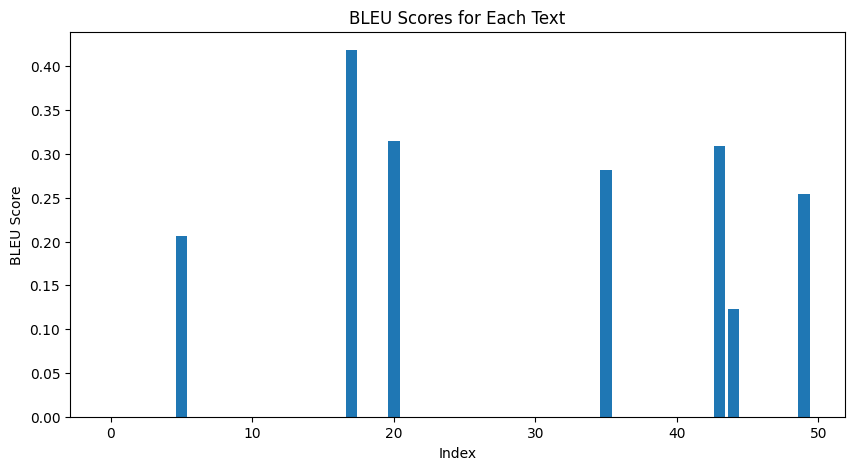

In [18]:
# Bar plot of BLEU scores
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['BLEU'])
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Each Text')
plt.show()

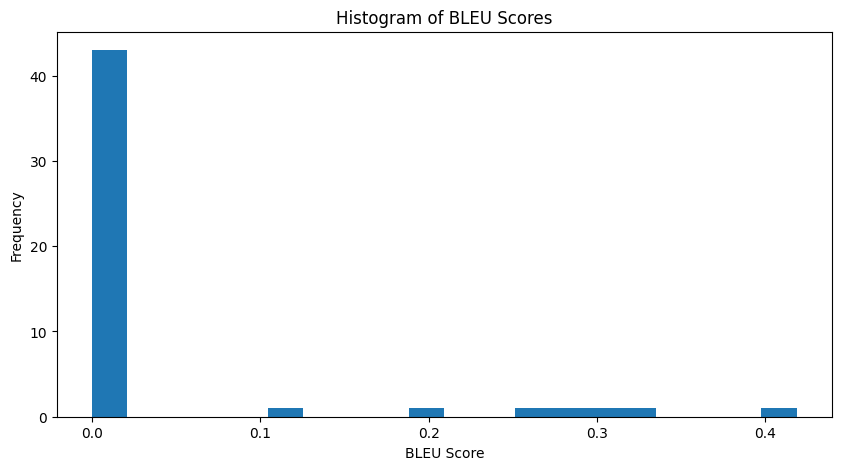

In [19]:
# Histogram of BLEU scores
plt.figure(figsize=(10, 5))
plt.hist(val_df['BLEU'], bins=20)
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Histogram of BLEU Scores')
plt.show()

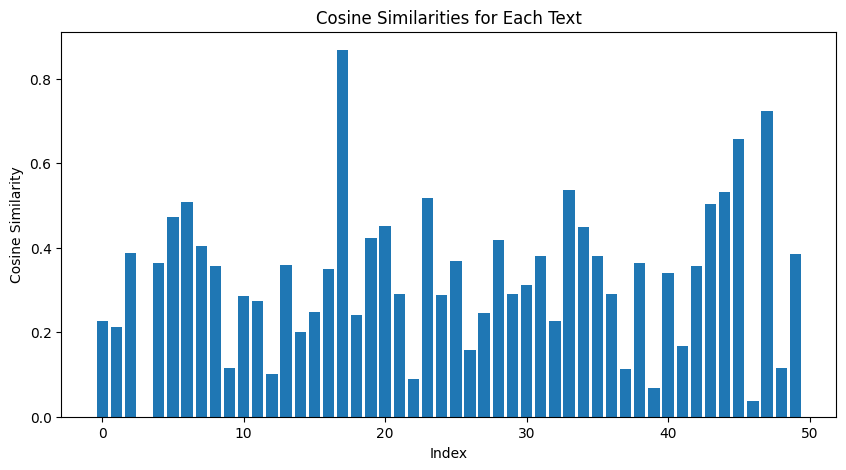

In [20]:

# Bar plot of cosine similarities
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['cosine'])
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarities for Each Text')
plt.show()

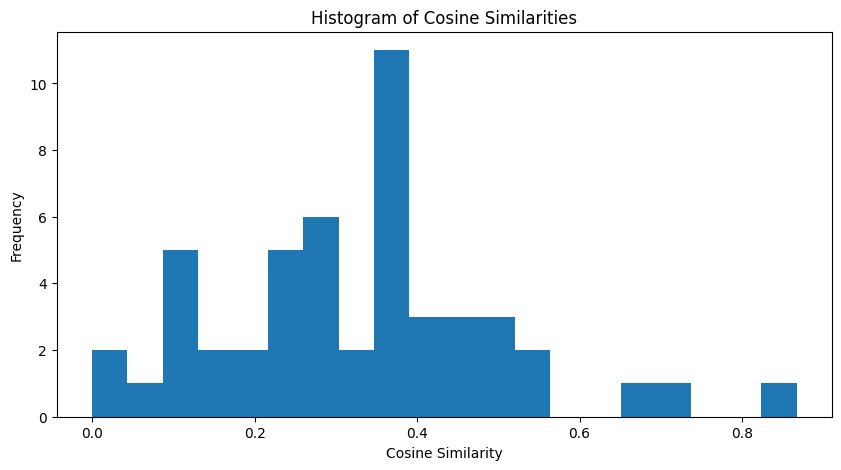

In [21]:
# Histogram of cosine similarities
plt.figure(figsize=(10, 5))
plt.hist(val_df['cosine'], bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()